In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import backend
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
from PIL import Image
import os 
import time

In [ ]:
BATCH_SIZE = 4
IMG_SIZE = (224, 224)

train_dir = "Data/"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

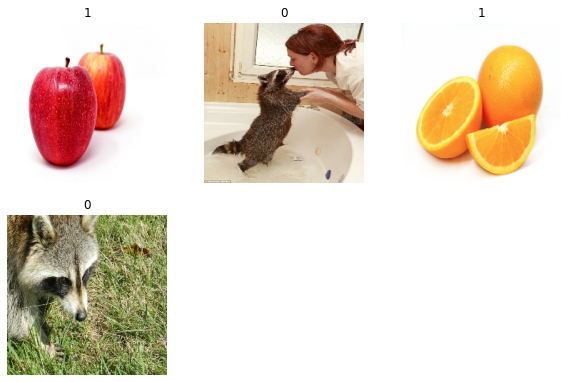

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 7, 7, 512)


In [5]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)
outputs = Dense(units=2)(x)
model = tf.keras.Model(inputs, outputs)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)             

In [9]:
hist = model.fit_generator(generator=train_dataset, epochs=3)#steps_per_epoch=1,

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
109/109 [==============================] - 12s 107ms/step - loss: 0.0783 - accuracy: 0.9954
Epoch 2/10
109/109 [==============================] - 11s 105ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
109/109 [==============================] - 11s 105ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
109/109 [==============================] - 11s 105ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
109/109 [==============================] - 11s 104ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
109/109 [==============================] - 11s 104ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
109/109 [==============================] - 11s 104ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
109/109 [==============================] - 11s 105ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
109/109 [==============================] - 11s 104ms/step - l

In [10]:
np.save('VGG.npy',model.weights)

In [11]:
model.weights[0].name

'block1_conv1/kernel:0'

In [11]:
data_dict2 = np.load('VGG.npy', encoding='latin1', allow_pickle=True)

In [12]:
#for i in (data_dict2):
#    print(i)
a = list(data_dict2)
a[6]
#a[1].numpy()

<tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-2.30123661e-03, -5.89181297e-03,  3.96523578e-03, ...,
           8.69934738e-04,  4.31257114e-03,  2.39815353e-03],
         [ 6.93455897e-03,  1.77669781e-03,  1.87194608e-02, ...,
          -3.17397565e-02, -4.21442185e-03, -1.76308881e-02],
         [-1.27900802e-02, -6.50780788e-03, -4.10286430e-03, ...,
           2.31482647e-03, -4.67822663e-02, -3.75668402e-03],
         ...,
         [-4.75286070e-04, -2.96283532e-02,  3.03538516e-02, ...,
           1.51648500e-03, -2.71695852e-02, -1.84430566e-03],
         [ 1.41743217e-02, -3.64480889e-04, -2.33754283e-03, ...,
          -2.28237733e-02, -1.60014853e-02,  2.46631019e-02],
         [ 1.18608214e-02, -2.77200472e-02, -2.48606838e-02, ...,
           4.10957001e-02,  5.57063818e-02, -2.19316985e-02]],

        [[-1.38294604e-03, -5.54690696e-03, -1.06138433e-03, ...,
           1.82250992e-03, -3.59015947e-04,  9.99924168e-03],
      

In [13]:
my_dict = {}
for var1, var2 in zip(*[iter(a)]*2):
    name = var1.name
    bc, _ = name.split("/")
    b = []
    b.append(var1.numpy())
    b.append(var2.numpy())
    my_dict[bc] = b

In [14]:
np.save('newVGG.npy', my_dict)

In [15]:
import numpy as np 
new_data_dict = np.load('newVGG.npy', encoding='latin1', allow_pickle=True).item()
for key,_ in enumerate(new_data_dict):
    print(_)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3
dense
dense_1
dense_2


In [23]:
data_dict = np.load('vgg16.npy', encoding='latin1', allow_pickle=True).item()

In [41]:
len(data_dict)

16

In [10]:
#print(data_dict)
for name,_ in enumerate(data_dict):
    print(_)

conv5_1
fc6
conv5_3
conv5_2
fc8
fc7
conv4_1
conv4_2
conv4_3
conv3_3
conv3_2
conv3_1
conv1_1
conv1_2
conv2_2
conv2_1
